## Convolutional Neural Networks
In machine learning, a convolutional neural network (CNN, or ConvNet) is a type of feed-forward artificial neural network in which the connectivity pattern between its neurons is inspired by the organization of the human visual cortex, whose individual neurons are arranged in such a way that they respond to overlapping regions tiling the visual field. Convolutional networks were inspired by biological processes and are variations of multilayer perceptrons designed to use minimal amounts of preprocessing. They have wide applications in image and video recognition, recommender systems and natural language processing [[weekipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)].

## Overview of the assignment
In this assignment we are going to build a **convolutional  neural network** that can take an image of a hand written digit and determine what digit is it.

To do this, you are going to use the **MNIST** dataset. MNIST *(Mixed National Institute of Standards and Technology database)* is a large dataset of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples[wikipedia]. More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.

Take a look at this demo to get an idea of what we are going to do:
http://scs.ryerson.ca/~aharley/vis/conv/flat.html

*This assignment is based on the tutorial on convolutional networks in [deeplearning.net](http://deeplearning.net/tutorial/lenet.html#lenet).*

## Get Prepared

We are using python and theano to implement our model. You are already familiar  with python from your previous assignment. Here I'll give you a bried introduction about theano.

### Theano
Theano is an opensource python library that allows to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently [[Theano paper](http://arxiv.org/pdf/1605.02688.pdf)].
In theano everything is symbolic. You define the computational graph with symbolic variables and operations and 
it will compile this graph and computes values of the variables based on the given inputs.

[Here](http://deeplearning.net/software/theano/theano.pdf) you can read and learn more about theano and [here](http://deeplearning.net/software/theano/install.html#install) you can find instructions on how to install it.

Take a look at this example to get some sense about how theano works: 

In [39]:
import theano
from theano.printing import pydotprint
from theano import tensor

# declare two symbolic floating-point scalars
a = tensor.dscalar()
b = tensor.dscalar()

# Here we are telling theano, how c is related to a and b with + operator.
c = a + b

# Then we can define a function to return the value of c based on given values for and b. 
# The syntax for doing this is: function_name = theano.function([inputs],[outputs])
f = theano.function([a,b], c)


Let's see how the computational graph looks like.

In [40]:
theano.printing.pydotprint(c, outfile="theano_graph_c.png", var_with_name_simple=True)  

The output file is available at theano_graph_c.png


This is how the output should look like:
<img src="theano_graph_c.png" >

And now we can call f like a function with values for a and b as its argument to get the value of c.

In [41]:
output = f(12,17)
print(output)

29.0


**<span class="girk">Excersise:**</span> Using theano define a function to calculate the distance between two vectors with the same length. (You can use any difinition of for the distance)

Hint: instead of definf a and b as tensor.dscalar() you should define them as tensor.vector() 

In [42]:
def compute_distance(x,y):
    raise NotImplementedException
    
a = np.array([1,2,3])
b = np.array([4,1,8])

print("Distance(%s,%s):" %(str(a),str(b)))

Distance([1 2 3],[4 1 8]):


## Implementation

### Required python packages

In [43]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

import os
import gzip
import pickle
import theano
import numpy as np
import pylab
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import theano
import theano.tensor as T
from theano.tensor.nnet import conv
from theano.tensor.signal import pool

print("Everything Imported Successfully.")

Everything Imported Successfully.


## Loading the data

You don't need to really understand what happens inside this *load_mnist_data()*. Briefly, it loads the MNIST data into theano shared variables and return these variables.

In [44]:
def load_mnist_data():
    filename = "data/mnist.pkl.gz"
    data_dir, data_file = os.path.split(filename)
    if data_dir == "" and not os.path.isfile(filename):
    # Check if dataset is in the data directory.
        new_path = os.path.join(
                    os.path.split(__file__)[0],
                    "..",
                    "data",
                    filename
                )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
                dataset = new_path

    if (not os.path.isfile(filename)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, filename)

    print('loading data ...')
    with gzip.open(filename, 'rb') as f:
        train_data, dev_data, test_data = pickle.load(f,encoding='latin1')

        def shared_dataset(data_xy, borrow=True):
            """ Function that loads the dataset into shared variables

            The reason we store our dataset in shared variables is to allow
            Theano to copy it into the GPU memory (when code is run on GPU).
            Since copying data into the GPU is slow, copying a minibatch everytime
            is needed (the default behaviour if the data is not in a shared
            variable) would lead to a large decrease in performance.
            """
            data_x, data_y = data_xy
            shared_x = theano.shared(np.asarray(data_x, dtype=theano.config.floatX),
                                         borrow=borrow)
            shared_y = theano.shared(np.asarray(data_y,dtype=theano.config.floatX),
                                         borrow=borrow)
            # When storing data on the GPU it has to be stored as floats
            # therefore we will store the labels as ``floatX`` as well
            # (``shared_y`` does exactly that). But during our computations
            # we need them as ints (we use labels as index, and if they are
            # floats it doesn't make sense) therefore instead of returning
            # ``shared_y`` we will have to cast it to int. This little hack
            # lets ous get around this issue
            return shared_x, theano.tensor.cast(shared_y, 'int32')

    test_set_x, test_set_y = shared_dataset(test_data)
    valid_set_x, valid_set_y = shared_dataset(dev_data)
    train_set_x, train_set_y = shared_dataset(train_data)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
                    (test_set_x, test_set_y)]
    return rval
  


As you can see *load_mnist_data()* returns three sets of data, *train_set*, *valid_set* and *test_set*. For each of these sets we have $x$ and $y$. $x$ contains the image feature vectors and $y$ contains images corresponding labels, which is the digit they represent.

We will use *train_set* and *valid_set* for training our model and *test_set* to measure the performance of the model.

Let's see the shapes of these variables:

In [45]:
(train_set_x, train_set_y), (valid_set_x, valid_set_y),(test_set_x, test_set_y) = load_mnist_data()
"""
A note on theano: since in theano every thing is symbolic, in order to get the value of a variable we need to
call the eval() function.
"""
    
print("train set shape, x: "+str(train_set_x.shape.eval()) + " y: " + str(train_set_y.shape.eval()))
print("valid set shape, x: "+str(valid_set_x.shape.eval()) + " y: " + str(valid_set_y.shape.eval()))
print("test set shape, x: "+str(test_set_x.shape.eval()) + " y: " + str(test_set_y.shape.eval()))


loading data ...
train set shape, x: [50000   784] y: [50000]
valid set shape, x: [10000   784] y: [10000]
test set shape, x: [10000   784] y: [10000]


As you can see each image in this dataset is represented with 28x28(784) pixels and it's corresponding label is a number between 0 and 9.
Here is how a sample image vector looks like:

In [46]:
print("Label: "+ str(train_set_y[0].eval()) +" image featire vector:" +str(train_set_x[0].eval()))

Label: 5 image featire vector:[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.      

We can visualize the input images using their feature vectors:

In [47]:
def show_digit(digit_vector):

    img = digit_vector.eval().reshape(28, 28)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1);
    plt.axis('off')
    ax.matshow(img, cmap=matplotlib.cm.binary)
    plt.show()

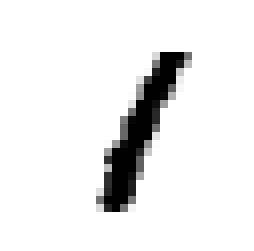

In [48]:
show_digit(train_set_x[105])

We want to implement a model which takes a digit image, it's feature vector, and predicts its value.

### Single Perceptron

Let's start by a single perceptron.

<img  src="perceptron.png">

The equation for a single perceptron is: $Y = activation(Wx+b)$
W is the weight matrix and b is the bias vector. In the problem of digit recognition the output, $Y$, is a vector of size 10. In order to predict what digit is the input image we apply $argmax$ on $Y$.

In [49]:
class Perceptron(object): #Y = activation( Wx + bias)
    
    def __init__(self, input, input_dim, output_dim):
        self.input = input #input is a vector or vectors of image features 
        self.input_dim = input_dim #input_dim is the size of each image feature vector. In our case it is 28*28
        self.output_dim = output_dim #output_dim is size of Y. In our case it should be the number if digits which is 10
        
        self.initialize_params() #in this function we initialize the wight values as theano shared variables.
        self.build_model() #in this function we tell theano how it should calculate output given input.
        
    def initialize_params(self): #initializing the weight matrix and the bias vector
        """np.zeros(shape,dtype) makes a matrix of shape shape and type dtype. 
        Here the we need W to be of shape (ouput_dim,input_dim) so W.X would be a vector size output_dim.
        """
        w_value = np.zeros((self.input_dim,self.output_dim), dtype=theano.config.floatX)
        #this is how we define a theano shared variable.
        self.W = theano.shared(value=w_value, name="W", borrow=True) 
        """
        The bias balue should be a vector of size output_dim
        """
        bias_value = np.zeros(self.output_dim, dtype=theano.config.floatX)
        self.bias = theano.shared(value=bias_value, name="bias", borrow=True)

        #we keep these parameters in a list so that later we can access them without the need to know what are they exactly.
        self.params = [self.W, self.bias] 

    def build_model(self): 
        """
        One thing you should note in here is that self.input is a list of image feature vectors not just a single one.
        More accurately the self.input.shape is (batch_size, image_feature_vector_size)
        """
        
        #We use the softmax function implemented in theano: T.nnet.softmax
        self.probabilities = T.nnet.softmax(T.dot(self.input,self.W) + self.bias)
        #Set the predicted digit to be the digit with the maximum probability. 
        #We have set axis=1, in order to determind the predicted digit for each row of the input matrix, ie. is for each image 
        self.predictions = np.argmax(self.probabilities,axis=1)
        
    def cost_function(self,train_y):
        return -T.mean(T.log(self.probabilities)[T.arange(train_y.shape[0]), train_y])
    def errors(self,y):
        return T.mean(T.neq(self.predictions, y))

In the above code, the *build_model* function is the part where we define the relations between input, output and the parameters of the model.

We choose the activation function to be softmax. Softmax squashes a K-dimensional vector of arbitrary real values to a K-dimensional vector of real values in the range (0, 1) that add up to 1 [[wikipedia](https://en.wikipedia.org/wiki/Softmax_function)]. This way we can assume $Y$ is a probabilistic distribution over all possible digits.
[Here](https://en.wikipedia.org/wiki/Softmax_function) you can read more about the softmax function.

So... we tell theano how to calculate the probabilities of the digits given the input image feature vector.
Then we define the predicted digit, to be the digit with the maximum probability.

What is the *cost_function* about?

Up to here, we have defined everything needed to have a perceptron which can predict the output given an input based on its parameter values that are set randomly. 
Well our perceptron might not perform very well if its parameters are not set properly. So we need to train our perceptron. Training the perceptron means changing it's parameter values until its output values are mostly correct. 

How do we do this? Well first, each time it makes a predictions it should know how far is its guess from the correct answer. Hence, we need to define a cost function that measures the difference between the predicted and correct answers and for training the perceptron, we try to modify its parameters to minimize this cost.  A gradient descent algorithm is used to update the parameters and minimize the cost function. You have already got familiar with it in your previous assignment.

In the end we define this error function so that we can see how many error does our model makes in its predictions.

Now, lets see how our single perceptron performs before training. 
This step is called forward pass. 

In [50]:
#we need to define the input node as a theano variable
x = T.matrix('x')
batch_size = 500 # We are going to feed the image feature vectors to the perceptron in batches of size 500. Why?
input_layer = x.reshape((batch_size,28*28))

#initialize and object of type perceptron
perc_layer = Perceptron(input=input_layer, 
                               input_dim=28*28, 
                               output_dim=10)

#now we
get_prediction = theano.function([x],perc_layer.predictions)
output = get_prediction(train_set_x[0:batch_size].eval())

for t,y in zip(train_set_y[0:10].eval(),output[0:10]):
    print("Target: "+str(t)+" Predicted: "+str(y))


Target: 5 Predicted: 0
Target: 0 Predicted: 0
Target: 4 Predicted: 0
Target: 1 Predicted: 0
Target: 9 Predicted: 0
Target: 2 Predicted: 0
Target: 1 Predicted: 0
Target: 3 Predicted: 0
Target: 1 Predicted: 0
Target: 4 Predicted: 0


Let's take a look at one of the probability distributions:


In [51]:
get_probability = theano.function([x],perc_layer.probabilities)
print(get_probability(train_set_x[0:batch_size].eval())[0])

[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


The perceptron doesn't know any thing about digits... :D 

<span class="girk">**Excersie:**</span> Try to initialize the parameters (W,b) in a different way and see what happens.

Let's train the perceptron:

In [52]:
# y is the label vectors.  we should define a theano variable for the labels so the theano can
# compute the cost.
y = T.ivector('y') 

#Here we are defining how the parameter values should be updated after each forward pass
cost = perc_layer.cost_function(y)
grads = T.grad(cost, perc_layer.params)
learning_rate = 0.1
updates = [(param_i, param_i - learning_rate * grad_i) for param_i,grad_i in zip(perc_layer.params,grads)]
training_step = theano.function([x,y], [cost], updates=updates)

#Here we are defining how we want measure the performance of our model in the test phase
error = perc_layer.errors(y)
test_model = theano.function([x,y], error)



we can train the perceptron for multiple epoch. Let's do it for one epoch now: 

In [53]:
train_batch_count = train_set_x.shape[0].eval() // batch_size 
valid_batch_count = valid_set_x.shape[0].eval() // batch_size
test_batch_count = test_set_x.shape[0].eval() // batch_size

number_of_epochs = 1
print("training ...")
for epoch in range(number_of_epochs):
    batch_count = 1
    train_error = 0
    valid_error = 0
    for i in np.random.permutation(int(train_batch_count)):
        training_step(train_set_x[i*batch_size:(i+1)*batch_size].eval(),train_set_y[i*batch_size:(i+1)*batch_size].eval())

    for i in np.arange(int(valid_batch_count)):
        valid_error += test_model(valid_set_x[i*batch_size:(i+1)*batch_size].eval(),
                                    np.asarray(valid_set_y[i*batch_size:(i+1)*batch_size].eval(),dtype='int32'))
    
    for i in np.arange(int(train_batch_count)):
        train_error += test_model(train_set_x[i*batch_size:(i+1)*batch_size].eval(),
                                     np.asarray(train_set_y[i*batch_size:(i+1)*batch_size].eval(),dtype='int32'))

    valid_error = valid_error / valid_batch_count
    train_error = train_error / train_batch_count
    print("epoch: %i train accuracy: %f validation accuracy: %f" %(epoch, 1.0 - train_error,1.0 - valid_error))
    batch_count += 1


training ...
epoch: 0 train accuracy: 0.859080 validation accuracy: 0.876000


<span class="girk">**Excersize:**</span> Monitor the cost after each iteration ie. after each batch is processed. Increase and decrease the learning rate to see what happens? If you could set the learning rate dynamically, how do you think it should change over time?

Let's see the predictions for a small set of inputs:

In [54]:
output = get_prediction(train_set_x[0:batch_size].eval())

for t,y in zip(train_set_y[0:10].eval(),output[0:10]):
    print("Traget: "+str(t)+" Predicted: "+str(y))

Traget: 5 Predicted: 3
Traget: 0 Predicted: 0
Traget: 4 Predicted: 4
Traget: 1 Predicted: 1
Traget: 9 Predicted: 9
Traget: 2 Predicted: 2
Traget: 1 Predicted: 1
Traget: 3 Predicted: 3
Traget: 1 Predicted: 1
Traget: 4 Predicted: 4


Of course it's much better now. 
How do you think the weight matrix (W) looks like now? We will plot the weights mapping the input to each output unit seperately.

Weights for calculating the probability that the input image is representing 0:


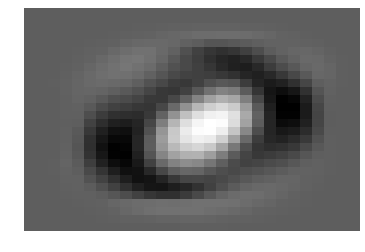

Weights for calculating the probability that the input image is representing 1:


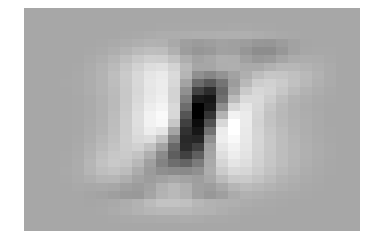

Weights for calculating the probability that the input image is representing 2:


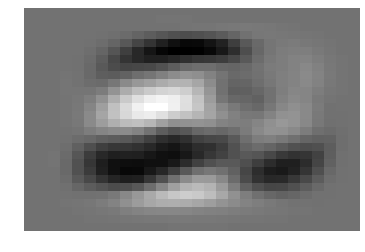

Weights for calculating the probability that the input image is representing 3:


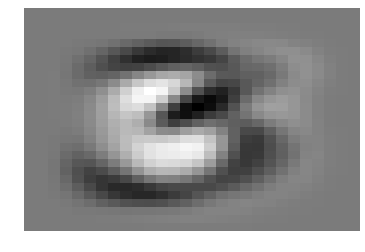

Weights for calculating the probability that the input image is representing 4:


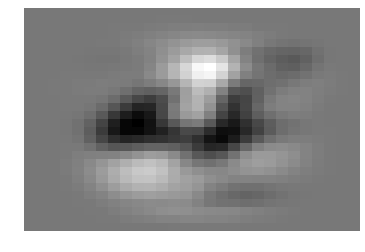

Weights for calculating the probability that the input image is representing 5:


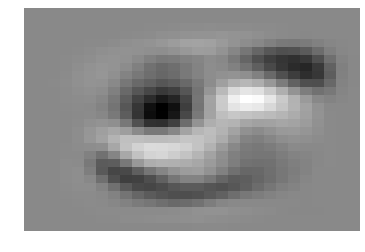

Weights for calculating the probability that the input image is representing 6:


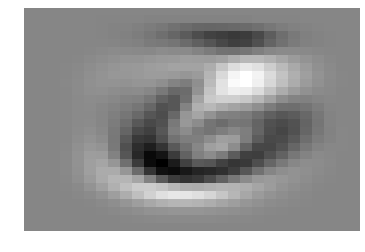

Weights for calculating the probability that the input image is representing 7:


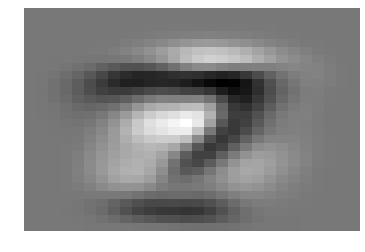

Weights for calculating the probability that the input image is representing 8:


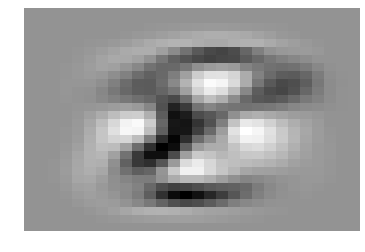

Weights for calculating the probability that the input image is representing 9:


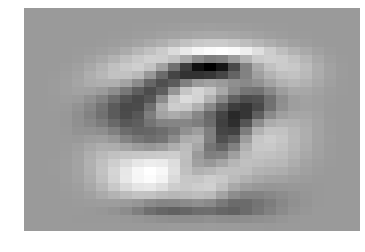

In [55]:
def show_weight_matrix(weight_matrix):
    fig = plt.figure()
    ax = fig.add_subplot(111);
    plt.axis('off')
    ax.imshow(weight_matrix, cmap=matplotlib.cm.binary,interpolation='nearest',aspect='auto')
    plt.show()

print("Weights for calculating the probability that the input image is representing 0:")
show_weight_matrix(perc_layer.W[:,0].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 1:")
show_weight_matrix(perc_layer.W[:,1].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 2:")
show_weight_matrix(perc_layer.W[:,2].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 3:")
show_weight_matrix(perc_layer.W[:,3].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 4:")
show_weight_matrix(perc_layer.W[:,4].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 5:")
show_weight_matrix(perc_layer.W[:,5].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 6:")
show_weight_matrix(perc_layer.W[:,6].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 7:")
show_weight_matrix(perc_layer.W[:,7].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 8:")
show_weight_matrix(perc_layer.W[:,8].eval().reshape(28,28))
print("Weights for calculating the probability that the input image is representing 9:")
show_weight_matrix(perc_layer.W[:,9].eval().reshape(28,28))



### Fully Connected Neural Network with One Hidden Layer
Now, we will extend our single perceptron to a single hidden layer fully connected  neural network, with 50 perceptrons:

<img src="mnist_and_mlp1.png">

In [56]:
class FullyConnectedLayer(object):
    def __init__(self, random_state, input, input_dim, output_dim, W=None, bias=None, activation=T.tanh):
        self.input = input
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.random_state = random_state
        self.activation = activation


        self.W, self.bias = self.initialize_weights(W, bias)
        self.params = [self.W,self.bias]

        linear_output = T.dot(input,self.W) + self.bias
        if activation is None:
            self.output = linear_output
        else:
            self.output = activation(linear_output)

    def initialize_weights(self, W, bias):
        if W is None:
            w_values = np.asarray(
                self.random_state.uniform(-np.sqrt(6.0 / (self.input_dim + self.output_dim)),
                                     np.sqrt(6.0 / (self.input_dim + self.output_dim)),
                                     (self.input_dim,self.output_dim))
                , dtype=theano.config.floatX)
            W = theano.shared(value=w_values, name="W", borrow="True")
            
        if bias is None:
            bias_values = np.zeros(self.output_dim, dtype=theano.config.floatX)
            bias = theano.shared(value=bias_values, name="bias", borrow="True")

        return W,bias    

Let's see the results of a feed forward pass:

In [57]:
#This is how we create a random number generator with numpy... we will use it to initialize parameters of the network.
rng = np.random.RandomState(23455)
x = T.matrix('x')
input_layer = x.reshape((batch_size,28*28))
#number_of_channels = 1 # out images have only 1 channel since they are balck and white images.
#input_layer = x.reshape((100,1,28*28))

full_layer = FullyConnectedLayer(
                    random_state=rng,
                    input=input_layer,
                    input_dim= 28*28,
                    output_dim=50,
                    activation=T.tanh
        )

perc_layer = Perceptron(input=full_layer.output, 
                               input_dim=full_layer.output_dim, 
                               output_dim=10)


get_prediction = theano.function([x],perc_layer.predictions)
output = get_prediction(train_set_x[0:batch_size].eval())

for t,y in zip(train_set_y[0:10].eval(),output[0:10]):
    print("Target: "+str(t)+" Predicted: "+str(y))


Target: 5 Predicted: 0
Target: 0 Predicted: 0
Target: 4 Predicted: 0
Target: 1 Predicted: 0
Target: 9 Predicted: 0
Target: 2 Predicted: 0
Target: 1 Predicted: 0
Target: 3 Predicted: 0
Target: 1 Predicted: 0
Target: 4 Predicted: 0


Basically we can train a single layer fully connected network the same way we trained our single perceptron.

In [58]:
y = T.ivector('y') 

#Here we are defining how the parameter values should be updated after each forward pass
cost = perc_layer.cost_function(y)
grads = T.grad(cost, perc_layer.params)
learning_rate = 0.1
updates = [(param_i, param_i - learning_rate * grad_i) for param_i,grad_i in zip(perc_layer.params,grads)]
training_step = theano.function([x,y], [cost], updates=updates)

#Here we are defining how we want measure the performance of our model in the test phase
error = perc_layer.errors(y)
test_model = theano.function([x,y], error)

number_of_epochs = 1
print("training ...")
for epoch in range(number_of_epochs):
    batch_count = 1
    train_error = 0
    valid_error = 0
    for i in np.random.permutation(int(train_batch_count)):
        training_step(train_set_x[i*batch_size:(i+1)*batch_size].eval(),train_set_y[i*batch_size:(i+1)*batch_size].eval())

    for i in np.arange(int(valid_batch_count)):
        valid_error += test_model(valid_set_x[i*batch_size:(i+1)*batch_size].eval(),
                                    np.asarray(valid_set_y[i*batch_size:(i+1)*batch_size].eval(),dtype='int32'))
    
    for i in np.arange(int(train_batch_count)):
        train_error += test_model(train_set_x[i*batch_size:(i+1)*batch_size].eval(),
                                     np.asarray(train_set_y[i*batch_size:(i+1)*batch_size].eval(),dtype='int32'))

    valid_error = valid_error / valid_batch_count
    train_error = train_error / train_batch_count
    print("epoch: %i train accuracy: %f validation accuracy: %f" %(epoch, 1.0 - train_error,1.0 - valid_error))
    batch_count += 1


training ...
epoch: 0 train accuracy: 0.679300 validation accuracy: 0.706000


<span class="mark">**Qeustion:**</span> What happens to the performance? Why?

<span class="girk">**Excersie:**</span> Run the training for more epochs, what happens?

<span class="girk">**Excersie:**</span> Increase and  decrease the number if perceptrons in the hidden layer, what happens?

### Convolutional Layer

Convolutional layer has two steps, convolution and pooling.

<img src="CNN_layer.png">

Natural images have the property of being stationary, meaning that the statistics of one part of the image are the same as any other part. This suggests that the features that we learn at one part of the image can also be applied to other parts of the image, and we can use the same features at all locations.

More precisely, having learned features over small (say 8x8) patches sampled randomly from the larger image, we can then apply this learned 8x8 feature detector anywhere in the image. Specifically, we can take the learned 8x8 features and convolve them with the larger image, thus obtaining a different feature activation value at each location in the image.

You can get an idea of what happens in the convolution step from this picture:

<img src="conv_gif.gif">

After obtaining features using convolution, we would next like to use them for classification. In theory, one could use all the extracted features with a classifier such as a softmax classifier, but this can be computationally challenging. Consider for instance images of size 96x96 pixels, and suppose we have learned 400 features over 8x8 inputs. Each convolution results in an output of size (96 − 8 + 1) * (96 − 8 + 1) = 7921, and since we have 400 features, this results in a vector of 892 * 400 = 3,168,400 features per example. Learning a classifier with inputs having 3+ million features can be unwieldy, and can also be prone to over-fitting.

To address this, first recall that we decided to obtain convolved features because images have the "stationarity" property, which implies that features that are useful in one region are also likely to be useful for other regions. Thus, to describe a large image, one natural approach is to aggregate statistics of these features at various locations. For example, one could compute the mean (or max) value of a particular feature over a region of the image. These summary statistics are much lower in dimension (compared to using all of the extracted features) and can also improve results (less over-fitting). We aggregation operation is called this operation pooling, or sometimes mean pooling or max pooling (depending on the pooling operation applied).
The following image shows how pooling is done over 4 non-overlapping regions of the image.

<img src="Pooling_schematic.gif">


The discriptions for this part are borrowed from [here](http://deeplearning.stanford.edu/wiki/index.php/UFLDL_Tutorial)

Here is the implementation of the convolution layer. We theano functions for convolution and pooling steps.

In [73]:
class ConvolutionLayer(object):
    
    def __init__(self, input,random_state, image_shape, filter_shape, pooling_size):
        self.input = input
        self.pooling = pooling_size
        self.random_state = random_state
        self.input_dim = np.prod(filter_shape[1:])
        self.output_dim = filter_shape[0] * np.prod(filter_shape[2:]) // np.prod(self.pooling)
        self.filter_shape = filter_shape
        self.W, self.bias = self.initialize_weights()

        conv_out = conv.conv2d(input=input,filters=self.W,filter_shape=filter_shape,image_shape=image_shape)
        pooled_out = pool.pool_2d(input=conv_out, ds=pooling_size, ignore_border=True)

        self.output = T.tanh(pooled_out + self.bias.dimshuffle('x',0,'x','x'))
        self.params = [self.W, self.bias]

    def initialize_weights(self):
         w_values = np.asarray(
             self.random_state.uniform(-np.sqrt(6.0 / (self.input_dim + self.output_dim)),
                                       np.sqrt(6.0 / (self.input_dim + self.output_dim)),
                                       self.filter_shape)
             , dtype=theano.config.floatX)


         W = theano.shared(value=w_values, name="W", borrow="True")

         bias_values = np.zeros(self.filter_shape[0], dtype=theano.config.floatX)
         bias = theano.shared(value=bias_values, name="bias", borrow="True")

         return W,bias
        



Lets see what is the output of a convolutional layer:

In [118]:
x = T.matrix('x')
number_of_channels = 1
input_layer = x.reshape((batch_size, number_of_channels, 28, 28))

conv_layer = ConvolutionLayer(random_state=rng,
                    input=input_layer,
                    image_shape=(batch_size,1,28,28),
                    filter_shape=(10,1,5,5),
                    pooling_size=(2,2))

f = theano.function([x],conv_layer.output)

output = f(train_set_x[0:batch_size].eval())

print(output[0].shape)

(10, 12, 12)


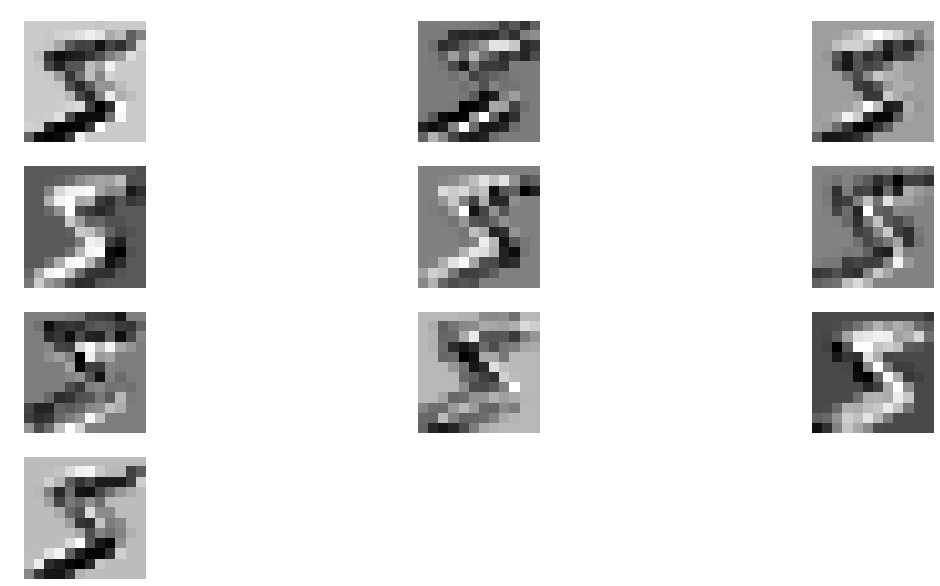

In [119]:
def show_images(vectors,shape=(12,12)): 
    
    fig = plt.figure(figsize=(20,10))
    
    ax={}
    for i in np.arange(len(vectors)):
        ax[i] = fig.add_subplot(int(np.sqrt(len(vectors)))+1, int(np.sqrt(len(vectors))), i+1)
        img = vectors[i].reshape(shape)
        
        plt.axis('off')
        ax[i].matshow(img, cmap=matplotlib.cm.binary)
    
    plt.axis('off')
    plt.show()
    
show_images(output[0])

<span class="girk">**Excersize:**</span> Change filter shape and pooling size, what happens?

### Putting Every thing together

Now lets put every thing together to build a convolutional network for digit recognition.
In this model we will feed the input to a convolutional layer, the output of the convolutional layer goes
through a fully connected hidden layer and the a single perceptron predicts the digit based on the output of 
the hidden layer.

This is an outline of what we want to build eventually:

<img src="fig1.png">

In [107]:
class ConvolutionalNetwork(object):

    def __init__(self, batch_size=500,input_shape= (1,28,28),numbers_of_feature_maps=[1,10],filter_shape=(5,5), pooling_size=(2, 2),output_size=10, learning_rate=0.1):
        self.input_shape = input_shape
        self.numbers_of_feature_maps = numbers_of_feature_maps
        self.filter_shape = filter_shape
        self.pooling_size = pooling_size
        self.learning_rate = learning_rate

        self.output_size = output_size
        self.batch_size = batch_size
        self.stride = 1
        self.zero_padding = 0
        self.calculate_image_shape_in_each_layer()


    def calculate_image_shape_in_each_layer(self):
        self.image_shape = np.zeros((len(self.numbers_of_feature_maps),2) , dtype=np.int)

        self.image_shape[0] = (self.input_shape[1],self.input_shape[2])
        for i in np.arange(1,len(self.image_shape),1):
            self.image_shape[i][0] = (((self.image_shape[i-1][0] - self.filter_shape[0] + 2*self.zero_padding)/ self.stride) + 1) / self.pooling_size[0]
            self.image_shape[i][1] = (((self.image_shape[i-1][1] - self.filter_shape[0] + 2*self.zero_padding)/ self.stride) + 1) / self.pooling_size[1]

    
    def build_model(self):
        x = T.matrix('x')
        y = T.ivector('y')
        self.input = x
        self.input_layer = x.reshape((self.batch_size, 1, self.image_shape[0][0], self.image_shape[0][1]))

        self.layers = {}
        self.layers[0] = ConvolutionLayer(
                    random_state=rng,
                    input=self.input_layer,
                    image_shape=(self.batch_size,self.numbers_of_feature_maps[0],self.image_shape[0][0],self.image_shape[0][1]),
                    filter_shape=(self.numbers_of_feature_maps[1],self.numbers_of_feature_maps[0],self.filter_shape[0],self.filter_shape[1]),
                    pooling_size=self.pooling_size

        )

    
        self.layers[1] = FullyConnectedLayer(
                    random_state=rng,
                    input=self.layers[0].output.flatten(2),
                    input_dim=self.numbers_of_feature_maps[1] * self.image_shape[1][0] * self.image_shape[1][1],
                    output_dim=256,
                    activation=T.tanh
        )

        self.layers[2] = Perceptron(input=self.layers[1].output, input_dim=self.layers[1].output_dim, output_dim=self.output_size)

        cost = self.layers[2].cost_function(y)
        error = self.layers[2].errors(y)
        self.predictions = self.layers[2].predictions
        all_params = self.layers[2].params + self.layers[1].params + self.layers[0].params

        grads = T.grad(cost, all_params)
        updates = [(param_i, param_i - self.learning_rate * grad_i) for param_i,grad_i in zip(all_params,grads)]
        self.training_step = theano.function([x,y], [cost], updates=updates)

        self.test_model = theano.function([x,y], error)
        self.predict_class = theano.function([x], self.predictions)


Now we will implement the digit recognizer which uses our convolutional network: 

In [108]:
class DigitRecognizer(object):
    def __init__(self):
        self.batch_size = 500
        self.initialize_data()
        self.model = ConvolutionalNetwork(batch_size=self.batch_size,input_shape=(1,28,28))


    def initialize_data(self):
        [self.train_x,self.train_y], [self.dev_x,self.dev_y], [self.test_x,self.test_y] = load_mnist_data()

        self.number_of_batches_in_train = self.train_x.get_value(borrow=True).shape[0] // self.batch_size
        self.number_of_batches_in_dev = self.dev_x.get_value(borrow=True).shape[0] // self.batch_size
        self.number_of_batches_in_test = self.test_x.get_value(borrow=True).shape[0] // self.batch_size

    def train_model(self):
        self.model.build_model()
        epochs = 5

        for epoch in range(epochs):
            # For each training example...
            for i in np.random.permutation(int(self.number_of_batches_in_train)):
                self.model.training_step(self.train_x[i*self.batch_size:(i+1)*self.batch_size].eval(),self.train_y[i*self.batch_size:(i+1)*self.batch_size].eval())

            valid_error = 0.
            train_error = 0.
            for i in np.arange(int(self.number_of_batches_in_test)):
                valid_error += self.model.test_model(self.test_x[i*self.batch_size:(i+1)*self.batch_size].eval(),self.test_y[i*self.batch_size:(i+1)*self.batch_size].eval())

            for i in np.arange(int(self.number_of_batches_in_train)):
                train_error += self.model.test_model(self.train_x[i*self.batch_size:(i+1)*self.batch_size].eval(),self.train_y[i*self.batch_size:(i+1)*self.batch_size].eval())


            valid_error = valid_error / valid_batch_count
            train_error = train_error / train_batch_count
            print("epoch: %i train accuracy: %f validation accuracy: %f" %(epoch, 1.0 - train_error,1.0 - valid_error))


Let's see how it works:

In [109]:
dr = DigitRecognizer()
dr.train_model()

loading data ...
epoch: 0 train accuracy: 0.886640 validation accuracy: 0.896900
epoch: 1 train accuracy: 0.909340 validation accuracy: 0.917900
epoch: 2 train accuracy: 0.922800 validation accuracy: 0.928600
epoch: 3 train accuracy: 0.931440 validation accuracy: 0.936600
epoch: 4 train accuracy: 0.938980 validation accuracy: 0.943900


Let's take a look at the output and weight matrix of each layer.

(10, 12, 12)


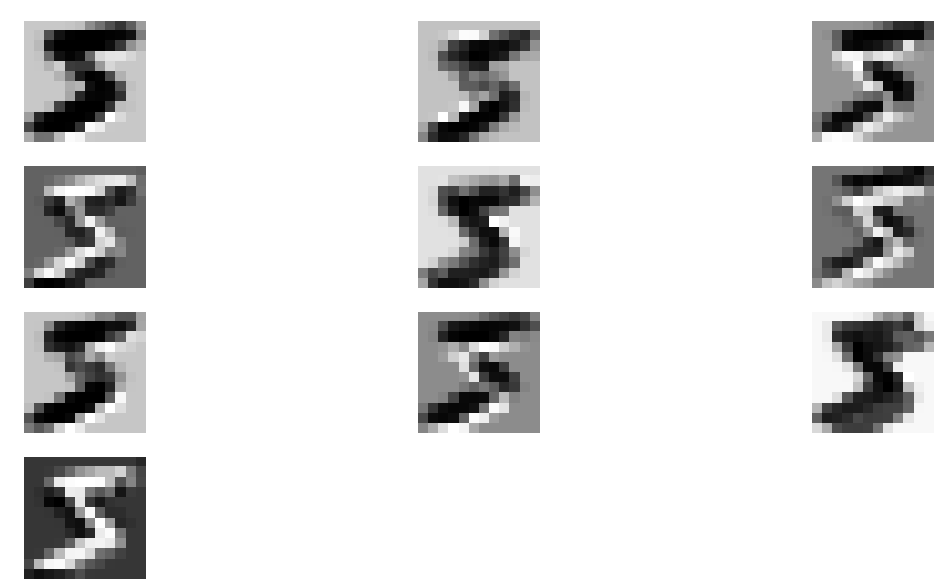

In [110]:
f = theano.function([dr.model.input],dr.model.layers[0].output)

output = f(train_set_x[0:dr.model.batch_size].eval())

print(output[0].shape)
show_images(output[0])

[10  1  5  5]


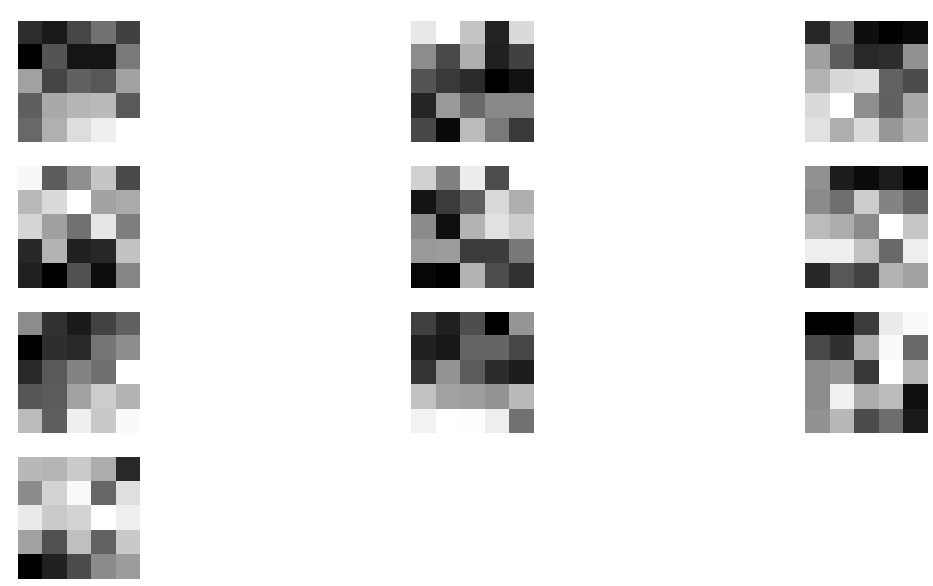

In [113]:
print(dr.model.layers[0].W.shape.eval())

#for i in np.arange(dr.model.layers[0].W.shape[0].eval()):
show_images(dr.model.layers[0].W[:,0].eval(),(5,5))

(256,)


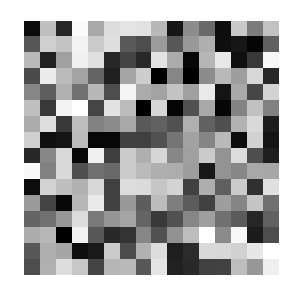

[10 12 12]


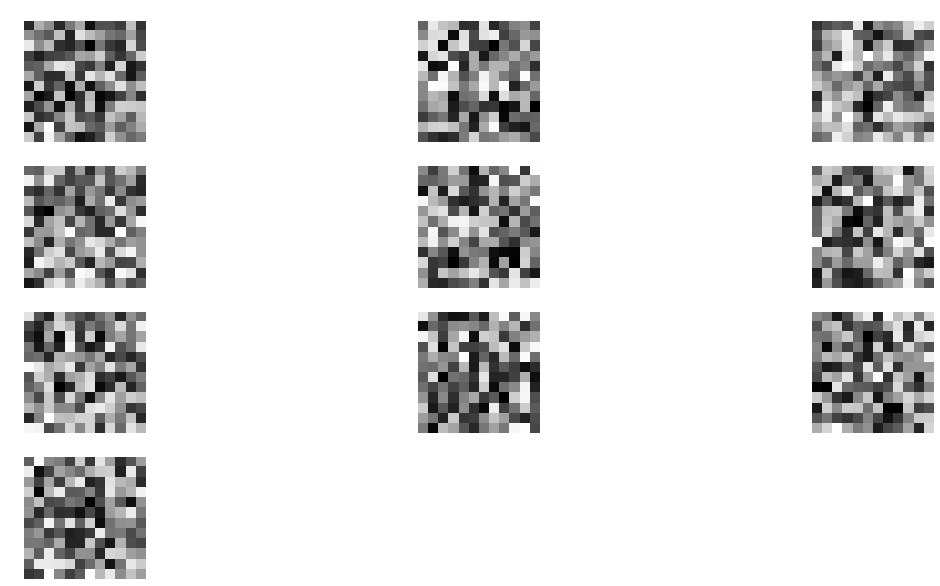

In [116]:
f = theano.function([dr.model.input],dr.model.layers[1].output)

output = f(train_set_x[0:dr.model.batch_size].eval())

print(output[0].shape)
image_size = int(np.sqrt(output[0].shape))
show_images(output[0:1],(image_size,image_size))

viz_model = dr.model.layers[1].W[:,0].reshape((dr.model.numbers_of_feature_maps[1],dr.model.image_shape[1][0],dr.model.image_shape[1][1]))
print(viz_model.shape.eval())
show_images(viz_model.eval(),(dr.model.image_shape[1][0],dr.model.image_shape[1][1]))

[256  10]


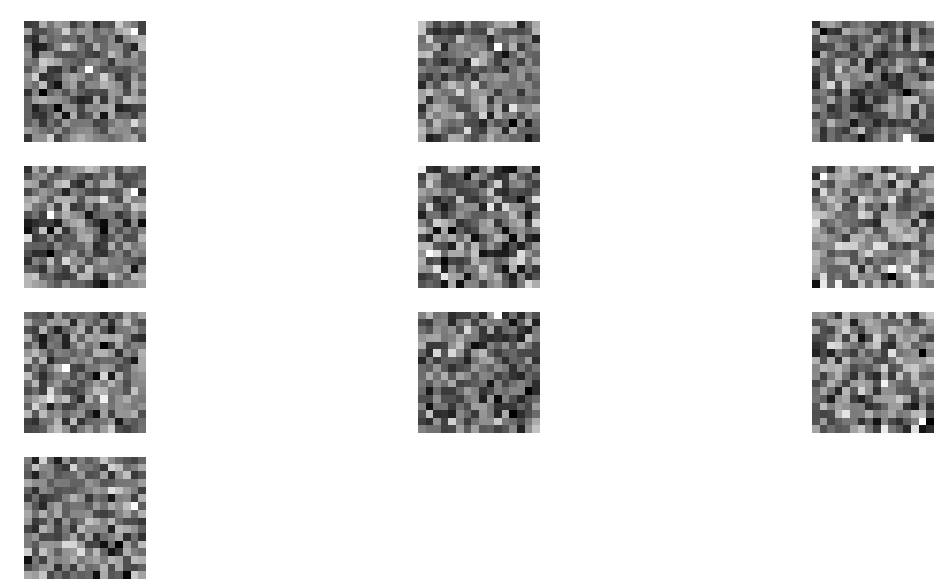

In [117]:
print(dr.model.layers[2].W.shape.eval())
image_size = int(np.sqrt(dr.model.layers[2].W.shape[0].eval()))
show_images(dr.model.layers[2].W.T.eval(),(image_size,image_size))

<span class="girk">**Excersise:**</span> Our current model only has one convolutional layer, add a second convolutional layer to it, and visualize the outputs and matrix weights.

<span class="girk">**Excersise:**</span> Change size of the hidden layer, filter shape and pooling size and re visualize the outputs and matrix weights.

## Convolutional Deconvolutional Neural Network

In the previous excersise you build a neural model that could learn to reproduce alphabet images. We can do this
with convolutional neural networks. Take a look at [this article](https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/).

<img src="conv_autoencoder.png">